In [92]:
import common
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

pd.options.display.max_columns = None # always display all columns in a Dataframe
pd.options.display.max_rows = None # same for the rows

OKY, the idea here is to compare the execution of the graph algorithms between those provided by the GAP.BS and those provided by the library, where available. Stinger comes with its own implementation of BFS, SSSP, WCC and PR; LLAMA of PR and BFS, same for GraphOne but the PR is so different that it makes no sense to compare it.


Data to load:

In [93]:
data = common.import_gfe("view_graphalytics_inserts").query("cluster == 'stones2'")
data["build_frequency_secs"] = data["build_frequency_secs"].fillna(0)
# data[:5] # just to see what's there

Compute the summaries for each graph and algorithm:

In [94]:
summaries = data.groupby(["library", "compiler_family", "graph", "build_frequency_secs", "num_threads_read", "num_threads_write", "algorithm"]).agg(completion_time=("median_secs", "median"), count=("median_secs", "count"))
summaries = summaries.unstack("algorithm")

Get the list of available executions:

In [95]:
fn_join_threads = lambda grp: ", ".join(map(str, grp.unique()))
summaries.reset_index().groupby(["library", "compiler_family"]).agg(num_threads=("num_threads_write", fn_join_threads))

,,num_threads
library,compiler_family,
g1_v4-bw-sp-ignore-build,gcc,"3, 6, 12"
g1_v4-ref-ignore-build,gcc,"3, 6, 12, 20"
livegraph_ro,gcc,20
llama6,gcc,16
llama6-ref,gcc,16
stinger5,gcc,"20, 40"
stinger5-ref,gcc,"20, 40"
teseo-dv.9,gcc,40
teseo-lcc-dv.9,gcc,40


Prepare the data:

In [96]:
# Stinger
stinger_native = summaries.loc[("stinger5", "gcc", slice(None), slice(None), slice(None), 40), "completion_time"].droplevel([0,1,3,4,5])
stinger_gapbs = summaries.loc[("stinger5-ref", "gcc", slice(None), slice(None), slice(None), 40), "completion_time"].droplevel([0,1,3,4,5])
stinger = pd.concat( [stinger_native / stinger_gapbs], names=['library'], keys=['stinger'] )
# LLAMA
llama_native = summaries.loc[("llama6", "gcc", slice(None), 10.0, slice(None), 16), "completion_time"].droplevel([0,1,3,4,5])
llama_ref = summaries.loc[("llama6-ref", "gcc", slice(None), 10.0, slice(None), 16), "completion_time"].droplevel([0,1,3,4,5])
llama = pd.concat( [llama_native / llama_ref] , names=['library'], keys=["llama"] )
# GraphOne
g1_native = summaries.loc[("g1_v4-bw-sp-ignore-build", "gcc", slice(None), 0, slice(None), 12), "completion_time"].droplevel([0,1,3,4,5])
g1_gapbs = summaries.loc[("g1_v4-ref-ignore-build", "gcc", slice(None), 0, slice(None), 12), "completion_time"].droplevel([0,1,3,4,5])
g1 = pd.concat( [g1_native / g1_gapbs], names=['library'], keys=['graphone'] )

# Final data
speedup = pd.concat( [stinger, llama, g1 ])
speedup

algorithm                   bfs      cdlp       lcc   pagerank      sssp  \
library  graph                                                             
stinger  dota-league   2.021748  0.992872  1.000247   1.160999  4.824633   
         graph500-22   3.452096  1.005264  1.001150   9.298210  8.026528   
         graph500-24   8.824797  1.001041       NaN  15.082731  9.983933   
         graph500-26  20.197229  0.978307       NaN  18.232644  9.997364   
         uniform-22    3.853086  0.986295  1.010869   1.202704  5.610110   
         uniform-24   11.512104  0.990429  0.997856   1.425896  6.997913   
         uniform-26   21.278009  0.996586  1.005026   1.567614  6.995387   
llama    dota-league   0.946996  0.572936       NaN   1.462707  1.494911   
         graph500-22   1.011812  0.770541       NaN  10.556589  0.877886   
         graph500-24   1.487265  0.658144       NaN  21.262629  0.455884   
         uniform-22    0.913087  0.946757  0.980745   2.143191  0.595346   
         uniform-24    1.281126  0.696811       NaN   2.261215  0.371342   
graphone dota-league   1.080176  1.053629  1.002889   1.143461  1.066358   
         graph500-22   1.170737  1.162486  0.999213   3.155735  0.986472   
         graph500-24   1.655716  1.388251       NaN   8.280799  1.014122   
         graph500-26   1.318149  0.987389       NaN  14.282759  0.986895   
         uniform-22    1.066395  1.496286  1.006629   1.306351  1.034623   
         uniform-24    1.185394  0.669239  1.010907   1.583424  1.049177   
         uniform-26    1.422569  1.000060  1.016527   1.681277  1.008271   

algorithm                   wcc  
library  graph                   
stinger  dota-league   0.324122  
         graph500-22   0.446463  
         graph500-24   0.612912  
         graph500-26   0.841455  
         uniform-22    0.500772  
         uniform-24    0.740911  
         uniform-26    0.779794  
llama    dota-league   2.669909  
         graph500-22   4.724101  
         graph500-24  14.893422  
         uniform-22    8.051645  
         uniform-24   20.498434  
graphone dota-league   0.841244  
         graph500-22   0.810322  
         graph500-24   0.961226  
         graph500-26   1.175021  
         uniform-22    0.318515  
         uniform-24    0.158576  
         uniform-26    0.108896

Final plot for the paper:

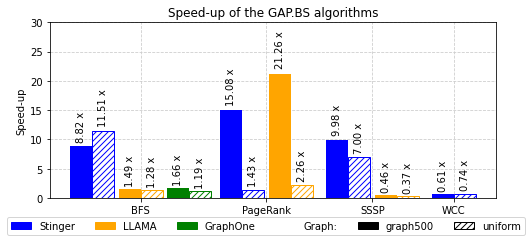

In [97]:
pt2inc = 1/72
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3.4))

plt.title("Speed-up of the GAP.BS algorithms")
plt.ylabel("Speed-up")
plt.ylim([0, 30])

# Grid lines
ax.set_axisbelow(True)
plt.grid(b=True, which='both', color='0.80', linestyle='--')

bar_width = 1
gap_minor = 0.2
# BFS
start_bfs = 0;
plt.bar(start_bfs + 0, speedup.loc[("stinger", "graph500-24"), "bfs"], bar_width, align="edge", color="blue")
plt.bar(start_bfs + 0 + bar_width, speedup.loc[("stinger", "uniform-24"), "bfs"], bar_width, align="edge", color="white", hatch="////", edgecolor="blue")
plt.bar(start_bfs + 2 * bar_width + gap_minor, speedup.loc[("llama", "graph500-24"), "bfs"], bar_width, align="edge", color="orange")
plt.bar(start_bfs + 3 * bar_width + gap_minor, speedup.loc[("llama", "uniform-24"), "bfs"], bar_width, align="edge", color="white", hatch='////', edgecolor="orange")
plt.bar(start_bfs + 4 * bar_width + 2* gap_minor, speedup.loc[("graphone", "graph500-24"), "bfs"], bar_width, align="edge", color="green")
plt.bar(start_bfs + 5 * bar_width + 2* gap_minor, speedup.loc[("graphone", "uniform-24"), "bfs"], bar_width, align="edge", color="white", hatch='////', edgecolor="green")

# PageRank
start_pagerank = start_bfs + 6 * bar_width + 4* gap_minor
plt.bar(start_pagerank, speedup.loc[("stinger", "graph500-24"), "pagerank"], bar_width, align="edge", color="blue")
plt.bar(start_pagerank + 1 * bar_width, speedup.loc[("stinger", "uniform-24"), "pagerank"], bar_width, align="edge", color="white", hatch="////", edgecolor="blue")
plt.bar(start_pagerank + 2 * bar_width + gap_minor, speedup.loc[("llama", "graph500-24"), "pagerank"], bar_width, align="edge", color="orange")
plt.bar(start_pagerank + 3 * bar_width + gap_minor, speedup.loc[("llama", "uniform-24"), "pagerank"], bar_width, align="edge", color="white", hatch='////', edgecolor="orange")

start_sssp = start_pagerank + 4 * bar_width + 4 *gap_minor
plt.bar(start_sssp, speedup.loc[("stinger", "graph500-24"), "sssp"], bar_width, align="edge", color="blue")
plt.bar(start_sssp + 1 * bar_width, speedup.loc[("stinger", "uniform-24"), "sssp"], bar_width, align="edge", color="white", hatch="////", edgecolor="blue")
plt.bar(start_sssp + 2 * bar_width + gap_minor, speedup.loc[("llama", "graph500-24"), "sssp"], bar_width, align="edge", color="orange")
plt.bar(start_sssp + 3 * bar_width + gap_minor, speedup.loc[("llama", "uniform-24"), "sssp"], bar_width, align="edge", color="white", hatch='////', edgecolor="orange")

start_wcc = start_sssp + 4 * bar_width + 4 *gap_minor
plt.bar(start_wcc, speedup.loc[("stinger", "graph500-24"), "wcc"], bar_width, align="edge", color="blue")
plt.bar(start_wcc + 1 * bar_width, speedup.loc[("stinger", "uniform-24"), "wcc"], bar_width, align="edge", color="white", hatch="////", edgecolor="blue")

# Groups
plt.xticks([
    start_bfs + bar_width * 3 + gap_minor, # BFS
    start_pagerank + (start_sssp - start_pagerank - 3* gap_minor) / 2.0, # PageRank
    start_sssp + (start_wcc - start_sssp - 3 * gap_minor) / 2.0, # SSSP
    start_wcc + bar_width, # WCC
], ["BFS", "PageRank", "SSSP", "WCC"])

# add a label at the top of each bar with its value
for rect in plt.gca().patches:
    value = rect.get_height();
    plt.gca().annotate(common.fmtlabel(value) + " x", xy=(rect.get_x() + rect.get_width() / 2, value * 1.02), xytext=(0,3), textcoords="offset points", ha="center", va="bottom", rotation="90")

# reduce the axes by 10% to leave some space to the legend
box = ax.get_position()
reduce_by = 0.05 # 0.1 == 10%
ax.set_position([box.x0, box.y0 + box.height * reduce_by, box.width, box.height * (1 - reduce_by)])
    
# insert the legend at the bottom of the plots
fig.legend(handles=[
    Patch(color="blue", label="Stinger"),
    Patch(color="orange", label="LLAMA"), 
    Patch(color="green", label="GraphOne"),
    Patch(color="white", label="Graph:"),
    Patch(color="black", label="graph500"), 
    Patch(facecolor="white", edgecolor="black", hatch="////", label="uniform"), 
], loc="lower center", ncol = 12)

# plt.savefig("/home/dean/workspace/eclipse/paper_gfe/img/plot_graphalytics_gapbs.svg", bbox_inches='tight')